In [1]:
import detectron2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

데이터셋은 `list[dict]` 의 형식으로 함수로 불러올 수 있어야 한다.

여기서 dict는 각 이미지에 대한 정보로 다음과 같은 형식이다.

```python
{
 'file_name': 이미지의 경로 (str),
 'image_id': 이미지 식별자 (str/int),
 'height': 이미지 세로길이 (int),
 'width': 이미지 가로길이 (int),
 'annotations': 이미지에 대한 라벨링 정보 (list[dict])
 }
```


`annotations` 은 각 instance에 대한 라벨링에 관한 dict 의 리스트이며, 각 dict의 형식은 다음과 같다.

```python
{
 'bbox': bounding box ([float, float, float, float]),
 'bbox_mode': bbox의 포맷으로 detectron2.structures의 BoxMode 중 하나이다 (int),
 'category_id': 카테고리 번호로 0~num_classes-1 중 하나이다. num_classes는 background의 번호로 쓰인다. (int)
}

```

BoxMode가 지원하는 bbox의 포맷은 다음이 있습니다.


* `XYXY_ABS = 0`  
  (x0, y0, x1, y1) in absolute floating points coordinates.  
  (x0, y0)은 왼쪽 위 좌표, (x1, y1)은 오른쪽 아래 좌표.


* `XYWH_ABS = 1`  
  (x0, y0, w, h) in absolute floating points coordinates.  
  (x0, y0)은 왼쪽 위 좌표, (w, h)은 너비, 높이.

`BoxMode.convert`을 이용해 서로 변환도 가능합니다.

In [2]:
from detectron2.structures import BoxMode

bbox = [20, 10, 100, 90]
BoxMode.convert(bbox, from_mode=BoxMode.XYXY_ABS, to_mode=BoxMode.XYWH_ABS)

[20, 10, 80, 80]

커스텀 데이터셋을 예시로 들겠습니다.

이 데이터의 정보는 json 파일로 되어있는데 첫번째 이미지에 대해 어떤식으로 저장되어 있는지 보면,

In [3]:
import json
from pprint import pprint

with open('/opt/ml/data/balloon/train/via_region_data.json') as f:
    example = next(iter(json.load(f).values()))

pprint(example, compact=True)

{'base64_img_data': '',
 'file_attributes': {},
 'filename': '34020010494_e5cb88e1c4_k.jpg',
 'fileref': '',
 'regions': {'0': {'region_attributes': {},
                   'shape_attributes': {'all_points_x': [1020, 1000, 994, 1003,
                                                         1023, 1050, 1089, 1134,
                                                         1190, 1265, 1321, 1361,
                                                         1403, 1428, 1442, 1445,
                                                         1441, 1427, 1400, 1361,
                                                         1316, 1269, 1228, 1198,
                                                         1207, 1210, 1190, 1177,
                                                         1172, 1174, 1170, 1153,
                                                         1127, 1104, 1061, 1032,
                                                         1020],
                                        'all_points_y':

이를 위에서 설명한대로 detectron2의 포맷에 맞춰 변환하는 함수를 생성해봅시다.

In [4]:
import os
import numpy as np
import cv2

def get_balloon_dicts(img_dir):

    dataset_dicts = []
    
    with open(os.path.join(img_dir, "via_region_data.json")) as f:
        imgs_anns = json.load(f)

    for idx, v in enumerate(imgs_anns.values()):

        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

DatasetCatalog에 이 함수를 등록해주면, get을 통해 dataset_dict을 불러올수 있다.
MetadataCatlog에는 class 정보를 thing_class에 넣어서 같은 이름으로 등록해준다.

In [5]:
for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")

In [6]:
balloon_dataset = DatasetCatalog.get("balloon_train")
pprint(balloon_dataset[0], compact=True)

{'annotations': [{'bbox': [994, 619, 1445, 1166],
                  'bbox_mode': <BoxMode.XYXY_ABS: 0>,
                  'category_id': 0,
                  'segmentation': [[1020, 963, 1000, 899, 994, 841, 1003, 787,
                                    1023, 738, 1050, 700, 1089, 663, 1134, 638,
                                    1190, 621, 1265, 619, 1321, 643, 1361, 672,
                                    1403, 720, 1428, 765, 1442, 800, 1445, 860,
                                    1441, 896, 1427, 942, 1400, 990, 1361, 1035,
                                    1316, 1079, 1269, 1112, 1228, 1129, 1198,
                                    1134, 1207, 1144, 1210, 1153, 1190, 1166,
                                    1177, 1166, 1172, 1150, 1174, 1136, 1170,
                                    1129, 1153, 1122, 1127, 1112, 1104, 1084,
                                    1061, 1037, 1032, 989, 1020, 963]]}],
 'file_name': 'balloon/train/34020010494_e5cb88e1c4_k.jpg',
 'height': 153

detectron2의 시각화툴을 이용해 확인해볼수 있다.

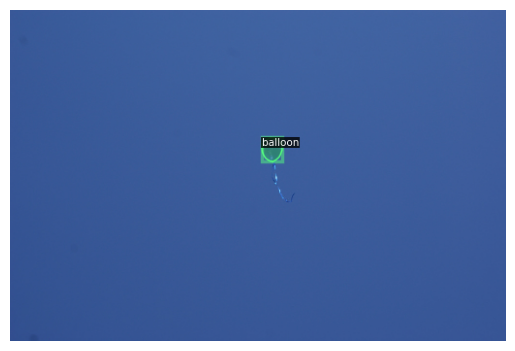

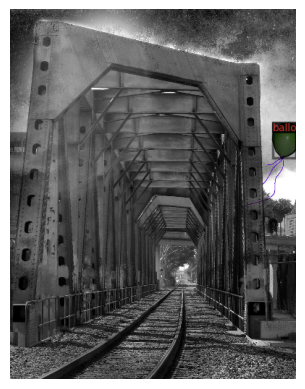

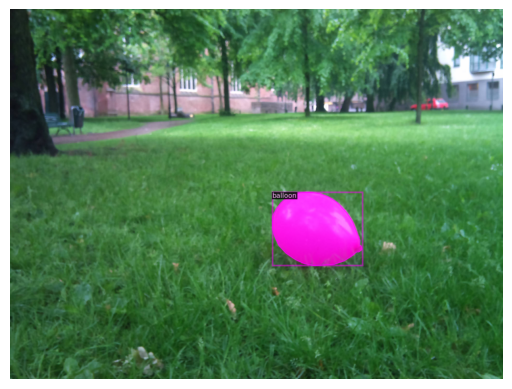

In [12]:
import random
import matplotlib.pyplot as plt

for d in random.sample(balloon_dataset, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image())
    plt.axis('off')
    plt.show()